# Hyperparameter Optimization

i.e. how to improve our model through **changing how our model is built**.

<img src="fig/frankestein.jpg" width="150"> <img src="fig/terminator.jpg" width="150"> <img src="fig/wolverine.png" width="150">

 **Hello There!**         

There are four fairly common strategies to optimize one model's hyperparameters.

<img src="fig/hyperparameter_meme_2.jpg" width="400">

*List in descending order of coolness*

Let's try applying some of these techniques to our titanic dataset

In [1]:
source('src/lib.R')

In [2]:
# import training and testing dataset

titanic_df = get_titanic_df()

## Grid Search

This is the stupidest plossibly conveivable method.
1. Try lots of combinations
2. Select the best one

It is also the simplest to implement and it is not a coincidence that it is natively built in *Caret*. 

The only thing you should do is to declare the parameter $\texttt{tuneGrid}$ when invoking *Caret*'s $\texttt{train}$ function.

Note that:
- $\texttt{tuneGrid}$ is initialized as NULL
- $\texttt{tuneGrid}$ must be passed a named $\texttt{data.frame}$ (plz read: "a table with column names :)")

Finding which hyperparameters can be passed to our train function is farily easy:

In [3]:
info = getModelInfo()
info$kknn$parameters

parameter,class,label
kmax,numeric,Max. #Neighbors
distance,numeric,Distance
kernel,character,Kernel


As we saw, *kknn* can be passed three parameters, two of which are of *numeric* type while the latter should be a *string*

> if you decide to pass a tuning grid, you **must** declare a data.frame which would include **all** the parameters available. In our case, a data.frame with three columns (and, ofc, at least one row)

While the concept of *kmax* argument may be of easy understanding, the same cannot be said of *distance* and *kernel*. As we saw in a previous lesson, to know more model-specific hyperparameters, you can refer to the reference manual of the given package, from which the model you are about to train is taken. 

In [4]:
info$kknn$library ## as easy as that

[1] "kknn"

And [here](https://cran.r-project.org/web/packages/kknn/kknn.pdf) you have it. It turns out that
- $\texttt{kmax}$ best number of k neighbours less or equal to k.
- $\texttt{distance}$ is the parameter of the [Minkowski distance](https://en.wikipedia.org/wiki/Minkowski_distance) which, as **everybody** knows, takes value in $(0;+\infty)$
- $\texttt{kernel}$ is Kernel function to use. Possible choices are "rectangular" (which is standard unweighted knn), "triangular", "epanechnikov" (or beta(2,2)), "biweight" (or beta(3,3)), "triweight"
(or beta(4,4)), "cos", "inv", "gaussian", "rank" and "optimal".

In [5]:
## istantiate the tuning grid

((tune_grid = expand.grid(kmax = 20, 
                        kernel = c('triangular',
                                   'rectangular',
                                   'epanechnikov',
                                   'biweight',
                                   'triweight',
                                   'cos',
                                   'inv',
                                   'gaussian',
                                   'rank',
                                   'optimal'),
                        distance = c(0.5, 0.1, 1, 2, 5, 10)
                        )
)
) %>% nrow %>% paste('This tune grid has ', ., ' rows!')

[1] "This tune grid has  60  rows!"

In [6]:
## train the model (you really don't want to run this)

set.seed(123) # to allow reproducibility of cross validation split

#model_grid_search = train(x = titanic_df$x_train,
#                          y = titanic_df$y_train$class,
#                          method = 'kknn',
#                          tuneGrid = tune_grid,
#                          trControl = trainControl(method = 'cv',
#                                                   p = 0.9,
#                                                   number = 10)
#                    )

#saveRDS(model_grid_search, 'data/model_grid_search.R')


# rather, we trained the model for you, how nice are we?!?

(model_grid_search = readRDS('data/model_grid_search.R'))

k-Nearest Neighbors 

918 samples
  8 predictor
  2 classes: 'Not', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 826, 826, 827, 826, 826, 826, ... 
Resampling results across tuning parameters:

  kernel        distance  Accuracy   Kappa    
  triangular     0.1      0.7810798  0.5370820
  triangular     0.5      0.7822145  0.5393684
  triangular     1.0      0.7953058  0.5660860
  triangular     2.0      0.7952938  0.5661749
  triangular     5.0      0.7876851  0.5520019
  triangular    10.0      0.7843884  0.5444032
  rectangular    0.1      0.7810798  0.5311686
  rectangular    0.5      0.7811037  0.5339270
  rectangular    1.0      0.7920091  0.5570212
  rectangular    2.0      0.7985905  0.5740086
  rectangular    5.0      0.7756928  0.5272391
  rectangular   10.0      0.7757286  0.5262589
  epanechnikov   0.1      0.7832418  0.5373270
  epanechnikov   0.5      0.7788939  0.5319887
  epanechnikov   1.0      0.7930960  0.5614046
  epanech

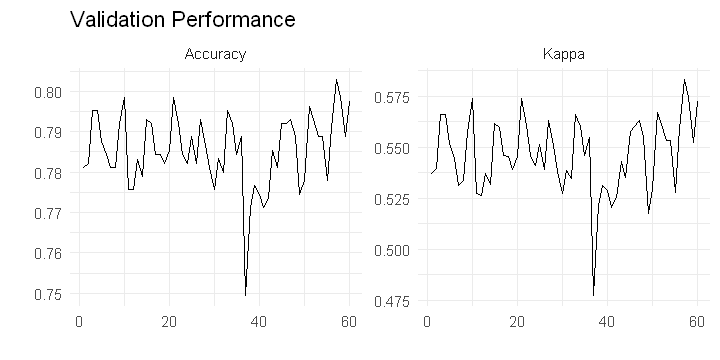

In [161]:
options(repr.plot.width=6, repr.plot.height=3)

model_grid_search$results %>%
  as_data_frame %>%
  rownames_to_column(var = 'id') %>% mutate(id = as.numeric(id))%>%
    gather(Variable, Value, -one_of('id', 'kmax', 'kernel', 'distance')) %>%
    filter(Variable == 'Accuracy' | Variable == 'Kappa') %>%
    ggplot() + geom_line(aes(x = id, y = Value)) + ggtitle('Validation Performance') +
    facet_wrap(~Variable, scales = 'free') + theme_minimal() + labs(x = "", y = "")

options(repr.plot.width=6, repr.plot.height=6)

Looks like there is a clear winner here!

In [11]:
model_grid_search$results %>% as_data_frame %>% top_n(1, Accuracy)
model_grid_search$results %>% as_data_frame %>% top_n(1, Kappa)

kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
20,optimal,1,0.8029503,0.5831926,0.05869298,0.1213537


kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
20,optimal,1,0.8029503,0.5831926,0.05869298,0.1213537


In [12]:
model_grid_search$bestTune # indeed

,kmax,distance,kernel
57,20,1,optimal


### Computational Issues

As you see, (if you tried training the model yourself) the model takes a **looong** time to train

Indeed, grid search is often not viable when the hyperparameter space gets lerger, indeed, it gets exponentially complex.

## Manual Search

This may seem trivial, but it actually requires a good undertstanding of the underlying problem + it can help in reducing the space of grid search.

## Random Search

grid search looked promising but is there a better way to do it?

Randomly sampling in the hyperparameter space may yield good results with less computing time. Also, it potentially allows us to explore an even larger hyperparameter space!

In [13]:
## train the model (you really don't want to run this)

set.seed(123) # to allow reproducibility of cross validation split

tune_grid_random = tune_grid %>% sample_n(10)

#model_random_search = train(x = titanic_df$x_train,
#                          y = titanic_df$y_train$class,
#                          method = 'kknn',
#                          tuneGrid = tune_grid_random,
#                          trControl = trainControl(method = 'cv',
#                                                   p = 0.9,
#                                                   number = 10)
#                    )

#saveRDS(model_random_search, 'data/model_random_search.R')


# rather we trained the model for you, how nice are we?!?

(model_random_search = readRDS('data/model_random_search.R'))

k-Nearest Neighbors 

918 samples
  8 predictor
  2 classes: 'Not', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 826, 828, 826, 826, 826, 826, ... 
Resampling results across tuning parameters:

  kernel        distance  Accuracy   Kappa    
  rectangular   10.0      0.7875121  0.5480525
  epanechnikov   0.1      0.7941787  0.5582882
  epanechnikov  10.0      0.7854348  0.5451215
  biweight       1.0      0.8017633  0.5813310
  biweight      10.0      0.7778261  0.5296114
  inv            5.0      0.7854589  0.5496455
  gaussian       0.5      0.7962560  0.5667048
  gaussian       5.0      0.7810386  0.5347831
  gaussian      10.0      0.7885990  0.5506830
  rank           1.0      0.7930435  0.5585456

Tuning parameter 'kmax' was held constant at a value of 20
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were kmax = 20, distance = 1 and kernel
 = biweight.

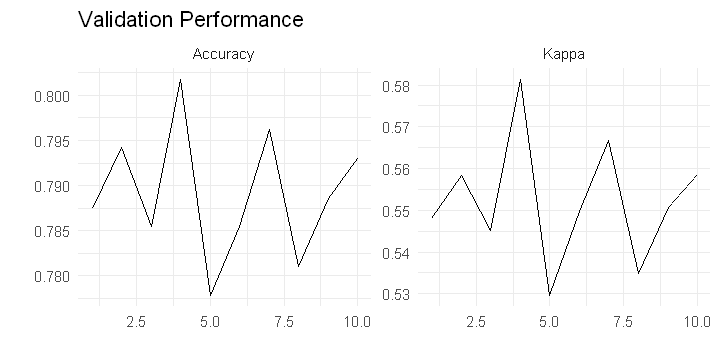

In [169]:
options(repr.plot.width=6, repr.plot.height=3)

model_random_search$results %>%
  as_data_frame %>%
  rownames_to_column(var = 'id') %>% mutate(id = as.numeric(id))%>%
    gather(Variable, Value, -one_of('id', 'kmax', 'kernel', 'distance')) %>%
    filter(Variable == 'Accuracy' | Variable == 'Kappa') %>%
    ggplot() + geom_line(aes(x = id, y = Value)) + ggtitle('Validation Performance') +
    facet_wrap(~Variable, scales = 'free') + theme_minimal() + labs(x = "", y = "")

options(repr.plot.width=6, repr.plot.height=6)

In [16]:
model_random_search$results %>% as_data_frame %>% top_n(1, Accuracy)
model_random_search$results %>% as_data_frame %>% top_n(1, Kappa)

kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
20,biweight,1,0.8017633,0.581331,0.05057195,0.1055897


kmax,kernel,distance,Accuracy,Kappa,AccuracySD,KappaSD
20,biweight,1,0.8017633,0.581331,0.05057195,0.1055897


Wow! with the 1/6th of training time we found a solution almost as good as than with grid search!
- note that despite this is not be the *best* hyperparameter set, it does they job fairly good, don't you think?

## Bayesian Optimization

[Google says](https://cloud.google.com/blog/big-data/2017/08/hyperparameter-tuning-in-cloud-machine-learning-engine-using-bayesian-optimization) it works the best.

This is a greedy approach (not a grid approach ;) ) in the sense that it is aimed at quickly maximize potentially locally optimal solution. Shoudl be relatively faster to other approaches if the hyperparameter space is particularly large! 
> if you think about it, finding the optimal solution would certainly mean overfitting!

### Gaussian Processes

Interestingly enough, Bayesian Hypermarameter Optimization relies on another machine learning algowitm (Gaussian Process) to **infer the latent accuracy (or loss)** distibution in the hyperparameters space, thus allowing a  more efficient search of hyperparameters which are looked after in the most **promising** regions. 

<img src="fig/escher.jpg" width="400"> <img src="fig/gaussian.png">

*Graphical representation of how to use a machine learning model to improve another machine learning model.*

Gaussian processes tries to infer the **prior distribution** of a phenomenon (in our case, the accuracy function) by looking at some realisation of that phenomenon, sampled from its **posterior distribution**. In the situation shown above, the true prior function $f(x) = x \sin(x)$ (red-dashed) is sampled at 6 different points (the red dots). Confidence bounds (the blue bands) for values in between the observation are set according to a *kernel* function. The default *kernel* in the **rBayesianOptimization** package is the **squared exponential kernel** $K_{SE}(x,x') = \exp \Big(-\frac{\|x-x'\|^2}{2\ell^2} \Big)$, The parameter ℓ is the characteristic length-scale of the process (practically, "how close" two points $x$ and $x'$ have to be to influence each other significantly).

___

Bayesian Hyperparameter Search proceeds by fitting a *gaussian process* to a initial set of randomly sampled hyperparameters and then inspecting the most *interesting* areas in the hyperparameter space, where *interesting* can be defined by an **acquisition function** (e.g. *expected improvement*, *probability of improvement*, *upper confidence bound*), which according to the current best hyperparameter estimate, calculates a new set of hyperparameter which is expected to maximize the accuracy gain.

Once a new hyperparameter set is choosen by the acquisition function, the underlying *gaussian process* is refit and the process iterates.
___

The function $\texttt{BayesianOptimization}$ from the **rBayesianOptimization** packages, automatically takes care of the underlying gaussian process. It must be passed the following inputs:
- $\texttt{FUN}$: the target function to be optimized. Must take in input the hyperparameters and output a list consising of
    1. Performance metric
    2. Response
- $\texttt{bounds}$: a named list specifying the search space for each individual hyperparameter
- $\texttt{init}$_$\texttt{points}$: the number of randomly sampled hyperparameters to initialize the gaussian process
- $\texttt{n}$_$\texttt{iter}$: the number of iterations beyond the initially randomly sampled sample
- $\texttt{acq}$: the acquisition function of choice

In [307]:
willBeOptimized = function(K, KERNEL, DIST){
  
#  partition = titanic_df$x_train %>% nrow %>% seq_len %>% createDataPartition(p = 0.9, list= FALSE)
  
#  x_train = titanic_df$x_train %>% slice(partition)
#  y_train = titanic_df$y_train %>% slice(partition)
    
#  x_val = titanic_df$x_train %>% slice(-partition)
#  y_val = titanic_df$y_train %>% slice(-partition)
    
    df = get_titanic_df()
    
  kernel = c('rectangular', # 1
             'triangular',  # 2
             'epanechnikov',# 3
             'biweight',    # 4
             'triweight',   # 5
             'cos',         # 6
             'inv',         # 7
             'gaussian',    # 8
             'rank',        # 9
             'optimal'      # 10                         
  )
  
  kernel = kernel[KERNEL]
  
  model = train(x = df$x_train, #x_train,
                y = df$y_train$class, #y_train$class,
                method = 'kknn',
               # trControl = trainControl(search = 'grid', method = 'none'),
                ks = K,
                tuneGrid = data.frame(kmax = 1,
                                      kernel = kernel,
                                      distance = DIST),
                trControl = trainControl(method = 'cv',
                                                   p = 0.9,
                                                   number = 10)
  )
  

acc =  model$results$Accuracy %>% max    
test_response = model$finalModel$data$.outcome

    
#  test_response = model %>%
#    predict(newdata = x_val) %>% factor
#  
#  acc = confusionMatrix(y_val$class,
#                        test_response)[['overall']]['Accuracy']
#
#  test_response_probabilities = model %>%
#    predict(newdata = x_val,
#           type = 'prob') %>% pull('Yes')
#     
#  roc = roc(test_response_probabilities,
#            y_val$class) %>% auc
#  
  return(list('Score' = acc,#roc,
              'Pred' = test_response))  
}

In [329]:
set.seed(123)

#bayesian_opt = BayesianOptimization(willBeOptimized,
#                          bounds = list(K = c(1L, 20L),
#                                        KERNEL = c(1L, 10L),
#                                        DIST = c(0.1, 10)),
#                          init_points = 10,
#                          n_iter = 30,
#                          acq = 'ucb',
#                          verbose = T)

#saveRDS(bayesian_opt, 'data/bayesian_opt.R')
bayesian_opt = readRDS('data/bayesian_opt.R')

elapsed = 3.60	Round = 1	K = 6.0000	KERNEL = 10.0000	DIST = 8.9064	Value = 0.7625 
elapsed = 4.25	Round = 2	K = 16.0000	KERNEL = 5.0000	DIST = 6.9588	Value = 0.7690 
elapsed = 4.37	Round = 3	K = 9.0000	KERNEL = 7.0000	DIST = 6.4410	Value = 0.7690 
elapsed = 6.22	Round = 4	K = 18.0000	KERNEL = 6.0000	DIST = 9.9433	Value = 0.7886 
elapsed = 6.55	Round = 5	K = 19.0000	KERNEL = 2.0000	DIST = 6.5915	Value = 0.7853 
elapsed = 5.06	Round = 6	K = 2.0000	KERNEL = 9.0000	DIST = 7.1145	Value = 0.7330 
elapsed = 5.07	Round = 7	K = 11.0000	KERNEL = 3.0000	DIST = 5.4863	Value = 0.7766 
elapsed = 5.99	Round = 8	K = 18.0000	KERNEL = 1.0000	DIST = 5.9820	Value = 0.7864 
elapsed = 4.95	Round = 9	K = 11.0000	KERNEL = 4.0000	DIST = 2.9627	Value = 0.7722 
elapsed = 5.24	Round = 10	K = 10.0000	KERNEL = 10.0000	DIST = 1.5564	Value = 0.7864 
elapsed = 4.86	Round = 11	K = 18.0000	KERNEL = 4.0000	DIST = 6.8924	Value = 0.7820 
elapsed = 6.83	Round = 12	K = 20.0000	KERNEL = 10.0000	DIST = 0.1000	Value = 0.7798 
e

In [330]:
bayesian_opt$History %>% as_data_frame %>% top_n(1, Value)

best_round = bayesian_opt$History %>% as_data_frame %>% top_n(1, Value) %>% pull('Round') %>% max

Round,K,KERNEL,DIST,Value
17,8,1,1.163896,0.7973244


As you can see in the plot below, the best hyperparameters maximize the accuracy along the tree different dimensions.

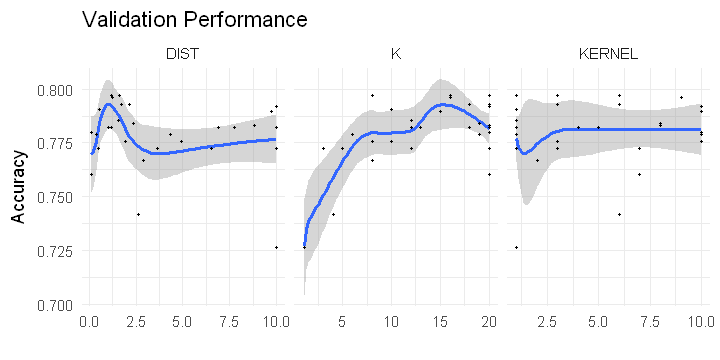

In [358]:
p = bayesian_opt$History %>%
gather(hp, Hyperparameters, -one_of('Value', 'Round')) %>%
filter(Round > 10) %>%
rename('Accuracy' = Value) %>%
ggplot(aes(x = Hyperparameters, y = Accuracy)) +
stat_smooth(method = 'loess', formula = y ~ exp(-abs(x)/x^2), se = T, level = 0.95) +
geom_point(size = 0.5) +
facet_grid(~ hp, scales = 'free') +
theme_minimal() + ggtitle('Validation Performance') + labs(x = "", y = "Accuracy")

options(repr.plot.width=6, repr.plot.height=3)

p

In [335]:
set.seed(123)

kernel = c('rectangular','triangular', 'epanechnikov', 'biweight', 'triweight', 'cos', 'inv', 'gaussian', 'rank', 'optimal')

model_bayesian_opt = train(x = titanic_df$x_train,
                            y = titanic_df$y_train$class,
                            method = 'kknn',
                            trControl = trainControl(search = 'grid', method = 'none'),
                            tuneGrid = data.frame(kmax = bayesian_opt$History$K[best_round],
                                              kernel = kernel[bayesian_opt$History$KERNEL[best_round]],
                                              distance = bayesian_opt$History$DIST[best_round])
                          )

saveRDS(model_bayesian_opt, 'data/model_bayesian_opt.R')

### Performance Recap | Training Sample

Let's summarise the in-sample performances of the trained models

In [336]:
model = readRDS('data/titanic_model.R')
model_grid_search = readRDS('data/model_grid_search.R')
model_random_search = readRDS('data/model_random_search.R')
model_bayesian_opt = readRDS('data/model_bayesian_opt.R')

data_frame(
'Manual Search' = model$results$Accuracy %>% round(3),
'Grid Search' = model_grid_search$results$Accuracy %>% round(3) %>% max,
'Random Search' = model_random_search$results$Accuracy %>% max %>% round(3) %>% max,
'Bayesian Search' = bayesian_opt$History$Value %>% max %>% round(3)
    ) %>% gather(key = 'Strategy', value = 'Accuracy') %>% arrange(desc(Accuracy))

Strategy,Accuracy
Grid Search,0.803
Random Search,0.802
Bayesian Search,0.797
Manual Search,0.782


> The main reason for which bayesian search has a significantly higher accuracy is because it can exploit non-integer value for the $\texttt{distance}$ parameter

### Performance Recap | Testing Sample

Let's test our models on the **hold-out** sample

In [337]:
test_response = model %>%  predict(newdata = titanic_df$x_test, type = 'raw') %>% factor
test_response_grid = model_grid_search %>% predict(newdata = titanic_df$x_test, type = 'raw') %>% factor
test_response_random = model_random_search %>% predict(newdata = titanic_df$x_test, type = 'raw') %>% factor
test_response_bayes = model_bayesian_opt %>% predict(newdata = titanic_df$x_test, type = 'raw') %>% factor

test_response_proba = model %>% predict(newdata = titanic_df$x_test, type = 'prob') %>% pull('Yes')
test_response_grid_proba = model_grid_search %>% predict(newdata = titanic_df$x_test, type = 'prob') %>% pull('Yes')
test_response_random_proba = model_random_search %>% predict(newdata = titanic_df$x_test, type = 'prob') %>% pull('Yes')
test_response_bayes_proba = model_bayesian_opt %>% predict(newdata = titanic_df$x_test, type = 'prob') %>% pull('Yes')

In [338]:
data_frame(
'Manual Search' = (acc = confusionMatrix(test_response, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Accuracy']  %>% round(3) %>% unlist,
'Grid Search' = (acc_grid = confusionMatrix(test_response_grid, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Accuracy'] %>% round(3) %>% list('Grid Search ' = .) %>% unlist,
'Random Search' = (acc_random = confusionMatrix(test_response_random, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Accuracy'] %>% round(3) %>% list('Random Search ' = .) %>% unlist,
'Bayesian Search' = (acc_bayes = confusionMatrix(test_response_bayes, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Accuracy'] %>% round(3) %>% list('Bayesian Search ' = .) %>% unlist
) %>% gather(key = 'Strategy', value = 'Accuracy') %>% arrange(desc(Accuracy))

Strategy,Accuracy
Grid Search,0.798
Manual Search,0.796
Bayesian Search,0.788
Random Search,0.758


In [339]:
data_frame(
'Manual Search' = (acc = confusionMatrix(test_response, titanic_df$y_test$class, positive = 'Yes'))[['byClass']]['Balanced Accuracy']  %>% round(3) %>% unlist,
'Grid Search' = (acc_grid = confusionMatrix(test_response_grid, titanic_df$y_test$class, positive = 'Yes'))[['byClass']]['Balanced Accuracy'] %>% round(3) %>% list('Grid Search ' = .) %>% unlist,
'Random Search' = (acc_random = confusionMatrix(test_response_random, titanic_df$y_test$class, positive = 'Yes'))[['byClass']]['Balanced Accuracy'] %>% round(3) %>% list('Random Search ' = .) %>% unlist,
'Bayesian Search' = (acc_bayes = confusionMatrix(test_response_bayes, titanic_df$y_test$class, positive = 'Yes'))[['byClass']]['Balanced Accuracy'] %>% round(3) %>% list('Bayesian Search ' = .) %>% unlist
) %>% gather(key = 'Strategy', value = 'Balanced Accuracy') %>% arrange(desc(`Balanced Accuracy`))

Strategy,Balanced Accuracy
Manual Search,0.776
Grid Search,0.775
Bayesian Search,0.763
Random Search,0.750


In [340]:
data_frame(
'Manual Search' = (acc = confusionMatrix(test_response, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Kappa']  %>% round(3) %>% unlist,
'Grid Search' = (acc_grid = confusionMatrix(test_response_grid, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Kappa'] %>% round(3) %>% list('Grid Search ' = .) %>% unlist,
'Random Search' = (acc_random = confusionMatrix(test_response_random, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Kappa'] %>% round(3) %>% list('Random Search ' = .) %>% unlist,
'Bayesian Search' = (acc_bayes = confusionMatrix(test_response_bayes, titanic_df$y_test$class, positive = 'Yes'))[['overall']]['Kappa'] %>% round(3) %>% list('Bayesian Search ' = .) %>% unlist
) %>% gather(key = 'Strategy', value = 'Kappa') %>% arrange(desc(Kappa))

Strategy,Kappa
Grid Search,0.548
Manual Search,0.547
Bayesian Search,0.525
Random Search,0.478


In [341]:
data_frame(
'Manual Search' = roc(test_response_proba, titanic_df$y_test$class) %>% auc,
'Grid Search' = roc(test_response_grid_proba, titanic_df$y_test$class) %>% auc,
'Random Search' = roc(test_response_random_proba, titanic_df$y_test$class) %>% auc,
'Bayesian Search' = roc(test_response_bayes_proba, titanic_df$y_test$class) %>% auc
) %>% gather(key = 'Strategy', value = 'AUC') %>% arrange(desc(AUC))

Strategy,AUC
Manual Search,0.8456319
Grid Search,0.8293264
Bayesian Search,0.8253195
Random Search,0.8123483


## Honest Toughts / Takeouts

- A better understanding of the problem and of the relationship and a good definition of the model/models to start with does the best of the work
    
- The larger the problem, the more incentive you have in going towards "smart" approaches, cf. Random Search and Bayesian Optimization. It is unlikely you will ever face a problem of a truly large size.

> The two above are especially true for complex problem, where the deadly combination of hyperparameter space size and training time are often called the **curse of dimensionality**


- If the problem is simple and/or well known, you'd be better off with a quick and dirty manual search.

- There is a lot of emphasis on gaining that little extra bit of performance (Kaggle competitions...), while a real-world task is pretty much aimed at finding a non useless solution. Basis-point improvement of AR are effectively worth nuts. 